In [212]:
# sources from other libraries
import random
import sys
import numpy as np
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
# Analyze versions of library sources
print ('Python: {} ' .format(sys.version))
print ('Numpy: {} ' .format(np.__version__ ))
print ('Pandas: {} ' .format(pd. __version__ ))
print ('Sklearn: {} ' .format(sklearn.__version__ ))

print ('Seaborn: {} ' .format(seaborn.__version__ ))


Python: 3.6.3 (default, Oct  4 2017, 06:09:38) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)] 
Numpy: 1.14.0 
Pandas: 0.22.0 
Sklearn: 0.19.1 
Seaborn: 0.8.1 


In [213]:
# Let's read the dataset and parse datatime inforamtion
df = pd.read_csv("data.csv", encoding = "latin-1", 
                 parse_dates=['auction_date', 'artist_birth_year', 'artist_death_year', 'year_of_execution'],
                infer_datetime_format = True)
df.head()

,artist_birth_year,artist_death_year,artist_name,artist_nationality,auction_date,category,currency,edition,estimate_high,estimate_low,hammer_price,location,materials,measurement_depth_cm,measurement_height_cm,measurement_width_cm,title,year_of_execution
0,1902-01-01,1982-01-01,Wifredo Lam,Cuban,1987-11-18 01:00:00,Painting,USD,NaN,NaN,NaN,280000.0,New York,oil on canvas,0,102,127,The night,1944
1,1902-01-01,1982-01-01,Wifredo Lam,Cuban,2005-06-12 00:00:00,Painting,EUR,NaN,NaN,NaN,30000.0,Versailles,Works on Paper,0,51,41,Untitled,1964
2,1902-01-01,1982-01-01,Wifredo Lam,Cuban,1994-05-17 00:00:00,Painting,USD,NaN,NaN,NaN,95000.0,New York,oil on canvas,0,79,102,idols,1955
3,1902-01-01,1982-01-01,Wifredo Lam,Cuban,1987-05-19 00:00:00,Unclassified,USD,NaN,NaN,NaN,2800.0,New York,Works on Paper,0,33,23,Camel,1973
4,1902-01-01,1982-01-01,Wifredo Lam,Cuban,2002-09-19 04:00:00,Unclassified,USD,NaN,2500.0,1500.0,1300.0,NaN,NaN,0,0,0,WIFREDO LAM,nan


In [214]:
## let's peak inside our dataset
# df.info()
# list(df)
# df.describe()
df.isnull().values.any() # if there is any null value in the dataset


True

In [215]:
# let's check how much data is missing
print(df.size) # tatal no of rows
print(df.dropna().size) ## how many rows do not have na values

1936404
33228


#### Let's randomly look at a sample from the dataset

In [216]:
df.sample(2) # Can see a lot of NaN values

,artist_birth_year,artist_death_year,artist_name,artist_nationality,auction_date,category,currency,edition,estimate_high,estimate_low,hammer_price,location,materials,measurement_depth_cm,measurement_height_cm,measurement_width_cm,title,year_of_execution
83463,1890-01-01,1976-01-01,Man Ray,American,1995-03-22 01:00:00,Photograph,GBP,NaN,NaN,NaN,3000.0,London,acrylic on masonite,0,33,41,Natural Paintings,1958
21815,1936-01-01,NaT,Frank Stella,American,1998-05-02 00:00:00,Painting,USD,NaN,7000.0,5000.0,21000.0,New York,Prints,0,61,173,The monkey rope,1993


##### Thoughts
- take year from auction date: define 'auction_after_death' and 'auction_after_birth' and impute missing value with `0` (drop auction date, artist_birth and artist_death)
- artist name: drop for regression
- artist_nationality: dummy variables for it
- category: create dummy variable
- currency: create dummy variable
- edison: droping this variable as not enough data for each dummy variable, also thought of creating unique/non-uniuqe binary variable but very less count for unique(179), lesser for other 
- estimate_high: normalise and use mean normalise  value for missing data imputation
- estimate_low: normalise and use mean normalise  value for missing data imputation
- location: create dummy variable: `new_york`/`london`/`...`
- material: droping it as a lot of very sparse dummy variables will be created
- measurement_height_cm	: normalised
- measurement_width_cm: normalised
- measurement_width_cm: normalised
- title: drop
- year_of execution: art_age (usign hammer date)


#### should delete all the column with no hammer price or impute it with zero!!!

In [217]:
# list(df)


#### Few problems in data
- 'n.d.' in time 
- string : `Circa\\r\\t\\t\\t\d\d\d\d` in timedate
- differnt format of date time
- OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 7401-01-01 00:00:00


In [218]:
### some data cleaning
df.replace(to_replace='Circa\\r\\t\\t\\t\d\d\d\d', value=0, regex=True, inplace = True)
df.replace(to_replace='n.d.', value=0, regex=False, inplace = True)



In [219]:
df_clean = df.copy()

#### Let's treat all available timedate and create useful featues from them
 - `auction_afer_death`
 - `auction_afer_birth`
 - `art_age`
 ##### will impute missing value with mean of the feature and  also drop the origin column
 - `auction_date`
 - `artist_death_year`
 - `artist_birth_year`
 - `year_of_execution`

In [220]:


df['auction_afer_death'] = (df['auction_date'].dt.year - df['artist_death_year'].dt.year)
df['auction_afer_birth'] = (df['auction_date'].dt.year - df['artist_birth_year'].dt.year)
df['art_age'] = df['auction_date'].dt.year - pd.to_datetime(df['year_of_execution'], errors='coerce').dt.year

df['auction_afer_death'] = df['auction_afer_death'].fillna((df['auction_afer_death'].mean()))
df['auction_afer_birth'] = df['auction_afer_birth'].fillna((df['auction_afer_birth'].mean()))
df['art_age'] = df['art_age'].fillna((df['art_age'].mean()))



df.drop(['auction_date', 'artist_death_year', 'artist_birth_year','year_of_execution' ], axis=1, inplace=True)

# ## artist_name is of no use for regression: dropping it
df.drop(['artist_name', 'edition', 'title'], axis=1, inplace=True)


In [221]:
df.sample(2)

,artist_nationality,category,currency,estimate_high,estimate_low,hammer_price,location,materials,measurement_depth_cm,measurement_height_cm,measurement_width_cm,auction_afer_death,auction_afer_birth,art_age
100087,American,(Screen)Print & Gravure,USD,10000.0,8000.0,6500.0,Van Nuys,aquatint and softground etching,0,6,5,18.29732,78,33.000000
37457,German,Painting,GBP,12000.0,8000.0,7000.0,London,acrylic and watercolor on card,0,99,76,-12.00000,57,31.374075


    - replaceing all very large values with `nan`
    - will fill them with `0` value



In [222]:

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

df.sample(2)

,artist_nationality,category,currency,estimate_high,estimate_low,hammer_price,location,materials,measurement_depth_cm,measurement_height_cm,measurement_width_cm,auction_afer_death,auction_afer_birth,art_age
94541,American,(Screen)Print & Gravure,GBP,4000.0,3000.0,3000.0,0,Screenprint on paper.,0,66,98,4.0,77,17.0
41187,French,Other works on paper,GBP,120000.0,90000.0,80000.0,London,distemper,0,48,56,59.0,131,89.0


## count of unique labels in all these categorical features
#### Let's create dummy variable for `artist_nationality`, `category` ,  ``currency``
- `material` and `location` has a lof of unique values, will drop it (as it will unnecessary increase our feature space and also won't provide enough information to the model to generalise 

In [223]:
for col in ['artist_nationality', 'category','currency', 'location', 'materials']:
    print(col)
    print("----"*20)
    temp = df[col]
    print(temp.value_counts(dropna = False) )
    print("----"*20)

artist_nationality
--------------------------------------------------------------------------------
American         46230
French           18514
British          14880
German           13094
Italian           3811
Chilean           1856
Russian           1453
Austrian          1404
Japanese          1324
Cuban             1272
Brazilian          973
Venezuelan         960
Greek              539
South African      495
Dutch              349
Mexican            282
Chinese            142
Name: artist_nationality, dtype: int64
--------------------------------------------------------------------------------
category
--------------------------------------------------------------------------------
Painting                      25710
(Screen)Print & Gravure       24780
Other works on paper          18554
Sculpture                     13702
Unclassified                   9200
Photograph                     6334
Drawing & Watercolor           3955
Etching                        2227
Collage    

In [224]:

df.drop(['location', 'materials'], axis=1, inplace=True) 

 # creating dummy variable
df = pd.get_dummies(df, prefix = ['currency','nationailty', 'category'], prefix_sep ="_",
               columns = ['currency','artist_nationality', 'category'] 
               ,sparse = False, dummy_na=False, drop_first= True)

# list(df)

In [225]:
df.sample(5)

,estimate_high,estimate_low,hammer_price,measurement_depth_cm,measurement_height_cm,measurement_width_cm,auction_afer_death,auction_afer_birth,art_age,currency_GBP,...,category_Film & Video,"category_Miniature, Object & Design",category_Mixed media,category_Other works on paper,category_Painting,category_Photograph,"category_Poster, Book, Postcard",category_Sculpture,category_Textile,category_Unclassified
84078,4000.0,3000.0,3000.0,0,25,30,24.00000,110,54.000000,1,...,0,0,0,0,0,0,0,0,0,0
93140,70000.0,50000.0,50000.0,0,86,122,18.29732,76,26.000000,0,...,0,0,0,0,1,0,0,0,0,0
25632,5000.0,4000.0,3000.0,0,15,18,48.00000,122,31.374075,0,...,0,0,0,0,1,0,0,0,0,0
38392,0.0,0.0,87000.0,0,61,74,52.00000,122,61.000000,0,...,0,0,0,0,1,0,0,0,0,0
32253,2500.0,1500.0,1600.0,0,39,56,18.29732,89,33.000000,0,...,0,0,0,0,0,0,0,0,0,0


### Let's split the datset into y and x
    - Y: hammer price
    - x: everything else
    
I have a lot of variables/predictors; therefore, I will be using l1 linear regression with k fold cross validaition for traning

In [226]:
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [227]:
# df = df.reset_index()
y_train = df[['hammer_price']] # response
x_train = df.drop(['hammer_price'], axis=1) # predictors
colnames = list(x_train) #  a list of all the feautes, we will need it while testing
# colnames
# df.head()##

In [228]:
print(y.shape)
print(x.shape)

(107578, 1)
(107578, 40)



####  Let's normalise the dataset so that it won't be biased to few features
    - we can normalise using the code in the cell below us or
    - by giving `normalize= True` while training the Linear regression model

In [229]:
## normalise method 1

y_train = y_train

x_train= x_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_train)
X_train= pd.DataFrame(x_scaled, columns=colnames)


In [230]:
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression, Lasso
import numpy as np


# Create linear regression object
linreg = LinearRegression(normalize=False) # training the normalise dataset is off

# Train the model using the training sets
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [231]:
y_true = y_train
y_pred = linreg.predict(X_train)

from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true, y_pred)
RMSE = np.sqrt(MSE)
print("Mean Square Error: {}".format(MSE))
print("Root Mean Square Error: {}".format(RMSE))

Mean Square Error: 202744642602.32114
Root Mean Square Error: 450271.7430644756


In [232]:
intercept = linreg.intercept_
coef = linreg.coef_

In [233]:
## Let's make a dataframe with each coeffficeint coefficeint in trained model
df_coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(coef))], axis = 1)
df_coefficients.columns = ['predictor', 'coefficient']
# df_coefficients[:10]

In [234]:
## Let sort the df_coefficient dataset based on coefficient
df_coefficients.sort_values(by = 'coefficient', ascending=False, inplace = True)


In [235]:
## Let's check the top tem features
df_coefficients[:10]

,predictor,coefficient
0,estimate_high,7.558097e+07
3,measurement_height_cm,2.757671e+06
4,measurement_width_cm,1.316247e+06
7,art_age,3.127213e+05
10,nationailty_Austrian,2.448191e+05
6,auction_afer_birth,7.342957e+04
17,nationailty_French,7.338285e+04
9,currency_USD,5.567159e+04
24,nationailty_South African,4.883989e+04
23,nationailty_Russian,4.112035e+04


#### Let's save our model and predictor_names: It will be helpful for prediction and we won't need to train our model again and again


In [236]:
import pickle


# Save to file `pickle_model.pkl` in the current working directory
pkl_filename = "pickle_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(linreg, file)


# Save to file `train_col.pkl`  in the current working directory
pkl_colnames = "train_col.pkl"  
with open(pkl_colnames, 'wb') as file:  
    pickle.dump(colnames, file)

  

In [460]:
def predict(pickle_model, pickle_colnames,  test_df ):
    """
    Input:
        - pickle_model: saved and trained pickle model
        - pickle_colname: saved predictor names used for training the model
        - test_df: dataframe we want to use for testing
    Output:
        - RMSE value: using provided and predicted hammer price
    """
    
    import pickle
    from sklearn.metrics import mean_squared_error
    import random
    import sys
    import numpy as np
    import pandas as pd 
    import sklearn
    
    
    # test data reading
    df = pd.read_csv(test_df, encoding = "latin-1", 
                 parse_dates=['auction_date', 'artist_birth_year', 'artist_death_year', 'year_of_execution'],
                infer_datetime_format = True)
    ## Test data cleaning
    df.replace(to_replace='Circa\\r\\t\\t\\t\d\d\d\d', value=0, regex=True, inplace = True)
    df.replace(to_replace='n.d.', value=0, regex=False, inplace = True)

    df['auction_afer_death'] = (df['auction_date'].dt.year - df['artist_death_year'].dt.year)
    df['auction_afer_birth'] = (df['auction_date'].dt.year - df['artist_birth_year'].dt.year)
    df['art_age'] = df['auction_date'].dt.year - pd.to_datetime(df['year_of_execution'], errors='coerce').dt.year

    df['auction_afer_death'] = df['auction_afer_death'].fillna((df['auction_afer_death'].mean()))
    df['auction_afer_birth'] = df['auction_afer_birth'].fillna((df['auction_afer_birth'].mean()))
    df['art_age'] = df['art_age'].fillna((df['art_age'].mean()))
    df.drop(['auction_date', 'artist_death_year', 'artist_birth_year','year_of_execution' ], axis=1, inplace=True)
    # ## artist_name is of no use for regression: dropping it
    df.drop(['artist_name', 'edition', 'title'], axis=1, inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    df.drop(['location', 'materials'], axis=1, inplace=True)
    df = pd.get_dummies(df, prefix = ['currency','nationailty', 'category'], prefix_sep ="_",
               columns = ['currency','artist_nationality', 'category'],
               sparse = False, dummy_na=True, drop_first= True)
    
    
    ## given value of y
    y_test = df[['hammer_price']] # response
    x_test = df.drop(['hammer_price'], axis=1) # predictors

    
    ## name of features provided in the current dataset (along with created dummy variable)
    test_colnames = list(x_test) 
    
    
    ## let's normalise x_test
    

    
    x_test= x_test.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_test_scaled = min_max_scaler.fit_transform(x_test)
    x_test= pd.DataFrame(x_test_scaled, columns=test_colnames)

    
    
    
    # Let's load the predictors lsit used for training the model
    with open(pickle_colnames, 'rb') as file:  
        train_colnames = pickle.load(file)
    # Get missing columns in the training test
    missing_cols = set(train_colnames) - set(test_colnames)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        x_test[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    x_test = x_test[train_colnames]
    
    
    # Loading the saved trained model file
    with open(pickle_model, 'rb') as file:  
        pickle_model = pickle.load(file)
        
    y_pred = pickle_model.predict(x_test)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    
    return RMSE
  
    

In [461]:
RMSE = predict('pickle_model.pkl','train_col.pkl','data.csv' )
RMSE

450271.7430644756

### Other Questions :
- Which features are most important for your model? Are there any that surprised to you? 
- How would you quantify the uncertainty and/or confidence intervals in the predictions? 
- How would you predict the price of a work if you were only given the artist name, type of work, and size?
- What happened to works by Sol Lewitt before, during and after the 2007-2008 financial crisis. How quickly did prices return to pre-2008 levels?  
- What additional data or features do you think would help increase performance?
- How would you determine the relationship between the size of works and their price?
- How would you make sure the works you're purchasing have uncorrelated returns (so that you can maintain a diverse portfolio)?
- What category of work do you recommend purchasing? 

###### which features are most important for your model? Are there any that surprised to you? 
    - we can check `df_coefficients` dataframe for this. it has all the predictors along with final coeffienct after trainign the weight.
    - `Venezuelan` and chilean vationality is affecting the price negatively whereas `Australian` an d`French` nationality has positive affect on the hammer price in positive 

In [240]:
# df_coefficients[:10]

#### How would you quantify the uncertainty and/or confidence intervals in the predictions? 
    - we need to calculate p-values and confidence interval for each of the predictors
    - one can calculate that by usign statsmodel library
    


##### How would you predict the price of a work if you were only given the artist name, type of work, and size?
- the predict function I wrote takes all teh trainign predictor name as an input, it will put those value to `0` while predicting and will give the output

#### What happened to works by Sol Lewitt before, during and after the 2007-2008 financial crisis. How quickly did prices return to pre-2008 levels?
   - After financial crisis price for Sol Lewitt trumblem, he must be a favourite of people working in financial domain
   - It haven't returned to 2008 levels

In [433]:
# df_clean['artist_name'].value_counts(dropna = False) ##Sol LeWitt 

# Let's create a boolean for aritst_name  = Sol Lewitt
sl = df_clean['artist_name'] == 'Sol LeWitt'
print('We have `2056 rows information for Sol Lewitt')
print('-----'*10)
print(sl.value_counts())

df_sl = df_clean.loc[sl] # slice dataset for Sol Lewitt
df_sl = df_sl[~df_sl.isin(['NaN', 'NaT','nan']).any(axis=1)]

print("-----"*10)
print("Let's plot how hammer price cahnged for Sil Lewitt over time")
print("-----"*10)

df_sl = df_sl[['hammer_price', 'auction_date']]
df_sl['auction_date']= df_sl['auction_date'].dt.year 


We have `2056 rows information for Sol Lewitt
--------------------------------------------------
False    105522
True       2056
Name: artist_name, dtype: int64
--------------------------------------------------
Let's plot how hammer price cahnged for Sil Lewitt over time
--------------------------------------------------


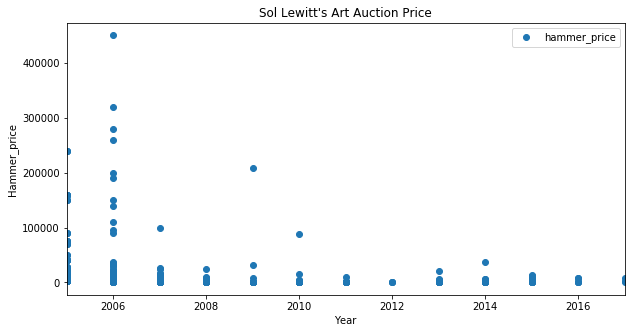

In [438]:
plt.figure(figsize=(10,5))
plt.scatter(df_sl.auction_date, df_sl.hammer_price, )
plt.xlabel('Year')
plt.ylabel('Hammer_price')
plt.xlim(2005,2017)
plt.title("Sol Lewitt's Art Auction Price")
plt.legend()
plt.show()

### What additional data or features do you think would help increase performance?
    - There is a lot of missing data, we first need to impove that
    - missing data is also in hammer price, in my opinion that is easy to gather
    - may be artist popularity rating would help improve the model
    


#### How would you determine the relationship between the size of works and their price?
    - we have `df_coefficients` dataframe. we can use that to get an idea of how each size is affecting price
    - `measurement_height_cm` and `measurement_width_cm` has positive impact whereas `measurement_depth_cm` has negative impact on the hammer price


#### How would you make sure the works you're purchasing have uncorrelated returns (so that you can maintain a diverse portfolio)?
 - you want to be diverse in terms to aritst, material. or predictors correlation with each other
 - we can make a correlation matrix to check predictor's correlation with each other 
 - and then can make purchase based on it

#### What category of work do you recommend purchasing? 
- `category_Other works on paper` has highest positive impact but it has a lot of options
- next is: `category_Drawing & Watercolor` and `category_sculpture`: to start with I would like to put my bet on these first

In [459]:
df_coefficients

,coefficient
predictor,
estimate_high,7.558097e+07
measurement_height_cm,2.757671e+06
measurement_width_cm,1.316247e+06
art_age,3.127213e+05
nationailty_Austrian,2.448191e+05
auction_afer_birth,7.342957e+04
nationailty_French,7.338285e+04
currency_USD,5.567159e+04
nationailty_South African,4.883989e+04
